In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [3]:
import re
import os
import io
import time
import numpy as np
import unicodedata

In [19]:
path_to_zip=tf.keras.utils.get_file('spa-eng.zip', 
                                 origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                   extract=True)

2646016/2638744 [==============================] - 0s 0us/step


In [20]:
path_to_file=os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [21]:
path_to_file

'/root/.keras/datasets/spa-eng/spa.txt'

In [22]:
#convert unicode file to ascii
#u"Klüft skräms inför på fédéral électoral große" ---> unicode version
#u"Kluft skrams infor pa federal electoral groe" ----> ascii version
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [23]:
def preprocess_sentence(w):
    w=unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [24]:
en_sentence = u"May I borrow this book?"
nl_sentence = u"¿Puedo tomar prestado este libro?"

In [25]:
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(nl_sentence))

<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>


In [26]:
unk_sentence="Klüft skräms inför på fédéral électoral große"
preprocess_sentence(unk_sentence)

'<start> kluft skrams infor pa federal electoral gro e <end>'

In [27]:
def create_dataset(path,num_examples):
    lines=io.open(path,encoding='UTF-8').read().strip().split('\n')
    word_pairs=[[preprocess_sentence(w) for w in line.split('\t')[0:2]] for line in lines[:num_examples]]
    
    return zip(*word_pairs)

In [28]:
en,nl=create_dataset(path_to_file,None)
l=len(en)
print(l)
for i in range(5):
    n=np.random.randint(l)
    print(en[n])
    print(nl[n])
    print("-----------------------------")


118964
<start> the island is warm all year . <end>
<start> la isla es calida todo el ano . <end>
-----------------------------
<start> don t be late to school again . <end>
<start> no vuelvas a llegar tarde al colegio . <end>
-----------------------------
<start> he didn t say in which year he was born . <end>
<start> el no dijo en que ano nacio . <end>
-----------------------------
<start> tom was shot by a policeman . <end>
<start> a tom le disparo un policia . <end>
-----------------------------
<start> i want more of that . <end>
<start> quiero mas de eso . <end>
-----------------------------


In [29]:
def tokenize(language):
    language_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='')
    language_tokenizer.fit_on_texts(language)
    tensor=language_tokenizer.texts_to_sequences(language)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor,language_tokenizer

In [30]:
tokenize(en[0])

(array([[ 1],
        [ 4],
        [ 2],
        [ 5],
        [ 6],
        [ 2],
        [ 3],
        [ 0],
        [ 7],
        [ 8],
        [ 0],
        [ 9],
        [ 0],
        [ 1],
        [10],
        [11],
        [12],
        [ 3]], dtype=int32),
 <keras_preprocessing.text.Tokenizer at 0x7fc25e97e590>)

In [31]:
def load_dataset(path,num_examples=None):
    targ_lang,inp_lang=create_dataset(path,num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor,target_tensor,inp_lang_tokenizer,targ_lang_tokenizer

In [32]:
num_examples = 100000
input_tensor,target_tensor,inp_lang,targ_lang=load_dataset(path_to_file, num_examples)

In [33]:
max_length_targ,max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ,max_length_inp)

17 20


In [34]:
input_tensor_train,input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [35]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [36]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print (" ")
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
37 ----> estoy
1985 ----> deseando
4 ----> que
557 ----> llegue
12 ----> la
616 ----> navidad
3 ----> .
2 ----> <end>
 
Target Language; index to word mapping
1 ----> <start>
4 ----> i
90 ----> am
257 ----> looking
987 ----> forward
7 ----> to
576 ----> christmas
3 ----> .
2 ----> <end>


In [37]:
buffer_size=len(input_tensor_train)
batch_size=64
steps_per_epoch = len(input_tensor_train)//batch_size
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [38]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20]), TensorShape([64, 17]))

Bahdanau attention for the encoder

FC = Fully connected (dense) layer

EO = Encoder output

H = hidden state

X = input to the decoder

pseudo-code:

score = FC(tanh(FC(EO) + FC(H)))

attention weights = softmax(score, axis = 1). Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.

context vector = sum(attention weights * EO, axis = 1). Same reason as above for choosing axis as 1.

embedding output = The input to the decoder X is passed through an embedding layer.

merged vector = concat(embedding output, context vector)

This merged vector is then given to the GRU

References:

https://www.tensorflow.org/tutorials/text/nmt_with_attention

https://arxiv.org/pdf/1409.0473.pdf

https://github.com/tensorflow/nmt

In [39]:
class Encoder(tf.keras.Model):
    
    def __init__(self,vocab_size,embedding_dim,enc_units,batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
    def call(self,x,hidden):
        x=self.embedding(x)
        output,state=self.gru(x,initial_state=hidden)
        return output,state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [40]:
encoder = Encoder(vocab_inp_size, embedding_dim, units,batch_size)

In [41]:
sample_hidden=encoder.initialize_hidden_state()

In [42]:
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [43]:
print (f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [44]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):

        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [45]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 20, 1)


In [46]:
class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [47]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, batch_size)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_size, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10785)


In [48]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [50]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * batch_size, 1)
    
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [51]:
epochs = 10

for epoch in range(epochs):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5489
Epoch 1 Batch 100 Loss 2.1116
Epoch 1 Batch 200 Loss 2.0521
Epoch 1 Batch 300 Loss 1.8592
Epoch 1 Batch 400 Loss 1.7546
Epoch 1 Batch 500 Loss 1.7540
Epoch 1 Batch 600 Loss 1.5703
Epoch 1 Batch 700 Loss 1.4615
Epoch 1 Batch 800 Loss 1.4870
Epoch 1 Batch 900 Loss 1.5539
Epoch 1 Batch 1000 Loss 1.2781
Epoch 1 Batch 1100 Loss 1.1866
Epoch 1 Batch 1200 Loss 1.1692
Epoch 1 Loss 1.6527
Time taken for 1 epoch 223.05416417121887 sec

Epoch 2 Batch 0 Loss 1.1712
Epoch 2 Batch 100 Loss 1.1311
Epoch 2 Batch 200 Loss 1.0302
Epoch 2 Batch 300 Loss 0.7353
Epoch 2 Batch 400 Loss 0.7840
Epoch 2 Batch 500 Loss 0.9653
Epoch 2 Batch 600 Loss 0.8258
Epoch 2 Batch 700 Loss 0.7271
Epoch 2 Batch 800 Loss 0.6632
Epoch 2 Batch 900 Loss 0.6744
Epoch 2 Batch 1000 Loss 0.6868
Epoch 2 Batch 1100 Loss 0.6506
Epoch 2 Batch 1200 Loss 0.7265
Epoch 2 Loss 0.8196
Time taken for 1 epoch 208.6992471218109 sec

Epoch 3 Batch 0 Loss 0.5288
Epoch 3 Batch 100 Loss 0.4748
Epoch 3 Batch 200 Loss 0.52

In [52]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [53]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [54]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [55]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


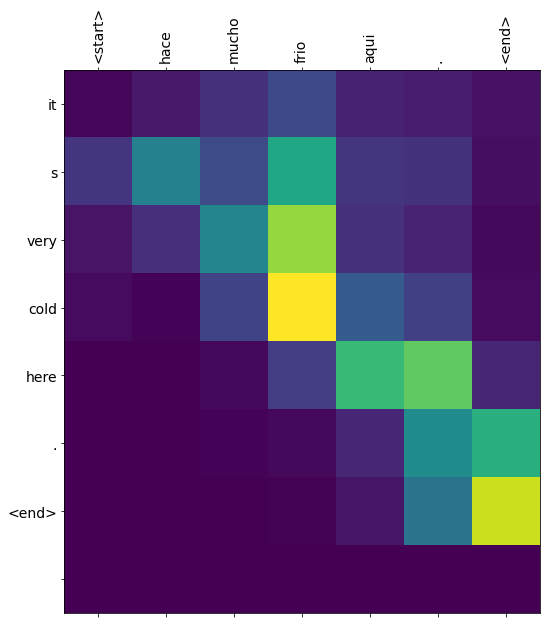

In [56]:
translate(u'hace mucho frio aqui.')